# Simulations of the Effects of the Diffusion of Rumours in Social Networks

The aim of this notebook is to verify that what was discussed in the theoretical proofs match with the reality. To do so, we first recreate the simulations for the diffusion of information done by Akbarpour & Jackson in their paper 'Diffusion in networks and the virtue of burstiness' to compare them with their results, and then create simulations for the diffusion of rumours to confirm our expectations from the theory.

In [1]:
import random # random generator
import networkx as nx # network 
import matplotlib.pyplot as plt # drawing graphs
import matplotlib as mpl
import numpy as np # Matrices
import seaborn as sns
import pandas as pd

The code utilizes an object-oriented approach with classes to represent nodes, allowing for the incorporation of an update function to determine their activity level and for the storage of relevant information such as if the node is infected, how many turns still has left to infect or if it is a debunker. Every type of node has its own class, that inherits the general characteristics of the node from the parent class Node. Each child class contains an update function to determine whether the node become active or not, based on specific criteria defined within the class.

In [3]:
class Node:
    def __init__(self, edges, lambda_, c_time):
        self.edges = edges
        self.lambda_ = lambda_
        self.c_time = c_time
        self.infected_turns = 0
        self.debunking_turns = 0
        self.disease = False
        self.debunker = False # if the node initially know that the rumour circulating is false

    def __str__(self):
        return f'The edges for the node are: {self.edges} \nThe value of lambda is: {self.lambda_}'

# to indicate the status of the node boolean values are used. True indicates that the node is active
# while False indicates that the node is inactive

class Sticky(Node):
    def __init__(self, edges, lambda_, c_time):
        super().__init__(edges, lambda_, c_time)

        # defining the initial status of the node
        if random.random() < self.lambda_: # with probability lambda_ the node is active
            self.status = True
        else: # with probability 1-lambda_ the node is inactive
            self.status = False

    def update_status(self): 
        # the update fuction does not do anything as for sticky nodes the true Markov chain 
        # is approximately a Markov chain in which the status of the node does not change over time
        pass

class Poisson(Node):
    def __init__(self, edges, lambda_, c_time):
        super().__init__(edges, lambda_, c_time)

        # defining the initial status of the node
        if random.random() < self.lambda_: # with probability lambda_ the node is active
            self.status = True
        else: # with probability 1-lambda_ the node is inactive
            self.status = False

    def update_status(self):
        # for the Poisson at every stage t the node has probability lambda_ to be active
        # and 1-lambda_ to be inactive
        if random.random() < self.lambda_:
            self.status = True
        else:
            self.status = False

class Reversing(Node):
    def __init__(self, edges, lambda_, c_time):
        super().__init__(edges, lambda_, c_time)

        # defining the initial status of the node
        if random.random() < self.lambda_: # with probability lambda_ the node is active
            self.status = True
        else: # with probability 1-lambda_ the node is inactive
            self.status = False

        # defining p_i and q_i depending on lambda_
        if self.lambda_ <= 0.5:
            self.p = 1
            self.q = self.lambda_/(1 - self.lambda_)
        else:
            self.p = (1-self.lambda_)/self.lambda_
            self.q = 1

    
    def update_status(self):
        # to update the status of a Reversing node the status of the node at time t must be known
        # as if it is active it has a probability of p to become inactive and 1-p to remain active
        # while if it is inactive it has a probability of q to become active and 1-q to remain inactive
        if self.status: # if it is active
            if random.random() < self.p: # here random.random() takes values in the interval [0,1) so if p is 1 it will always switch
                self.status = False
        else: # if it is inactive
            if random.random() < self.q:
                self.status = True

Every section and simulation is independent and can be run by itself

## Diffusion of Information
This section recreates the simulations done by Akbarpour & Jackson regarding the diffusion of information in networks.

The infection process is carried out by the function _infection()_, which is a recursive function that simulates the spread of a disease by checking the active neighbours of the infected nodes. The function takes as input the graph, a list of infected nodes that can spread the information, and the time of the interaction. To model the contagion process, the function iterates through the list of possible spreaders and, if the spreader is active, looks at its active neighbours and updates their values.

In [4]:
def infection(graph, contagious, t):
    """
    This recursive function does the infection process.

    Parameters:
        graph (list): the list of nodes already linked
        contagious (list): the list containing the contagious nodes
        t (int): current time

    Returns:
        list: the same graph after the infection process has finished
        list: a list with the still contagious nodes
        int: the time in which the infection stopped
    """
    # stopping case
    if len(contagious) == 0:
        return graph
    
    else:
        # infection process
        next_turn = []
        for node in contagious:
            # cases where the contagious node is not active
            if not node.status:
                # evaluating if the node should remain contagious
                if node.infected_turns < node.c_time - 1: # if the node has still some turns where it is contagious, add it to the next turn
                    node.infected_turns += 1
                    next_turn.append(node)
                else: # else just update the turns
                    node.infected_turns +=1

            # cases where the contagious node is active
            else:
                # check its neighbours
                for to_infect in node.edges:
                    if not to_infect.disease: # if the neighbour was not infected
                        if to_infect.status: # if the neighbour is active
                            to_infect.disease = True # infect the neighbour
                            next_turn.append(to_infect) # add it to the next turn

                # evaluating if the node should remain contagious
                if node.infected_turns < node.c_time - 1: # if the node has still some turns where it is contagious
                    node.infected_turns += 1
                    next_turn.append(node)
                else: # else just update the turns
                    node.infected_turns += 1

        # updating procedure
        for node in graph:
            node.update_status()
        
        t += 1
        return infection(graph, next_turn, t)

Other functions used in the simulations are for kickstarting the contagion process, either randomly or at one of the ends, and to assemble lines of nodes: 

In [5]:
def start_process_random(graph):
    """
    This function start the infection by selecting a random node.

    Parameters:
        graph (list): the list of nodes already linked

    Returns:
        list: the same graph with one random infected node
    """
    patient_zero = random.randint(0, len(graph)-1)
    graph[patient_zero].disease = True
    return [graph[patient_zero]]

def start_process_ends(graph):
    """
    This function start the infection by selecting randomly one of the end nodes.

    Parameters:
        graph (list): the list of nodes already linked

    Returns:
        list: the same graph with one random infected node
    """
    patient_zero = random.randint(0, 1)

    if patient_zero == 0:
        graph[patient_zero].disease = True
    else:
        graph[-1].disease = True

    return [graph[patient_zero]]

In [6]:
def assemble_line(nodes):
    """
    This function generates a line graph starting from a set of nodes.

    Parameters:
        nodes (list): list of ordered nodes

    Returns:
        list: a line graph
    """
    flag = 0
    while flag < len(nodes)-1:
        nodes[flag].edges.append(nodes[flag+1])
        nodes[flag+1].edges.append(nodes[flag])
        flag +=1
        
    return nodes

#### Check of the model

To verify that the code is in tune with the theoretical framework, we can calculate the theoretical probabilities of the possible combination of *sticky* and *poisson* nodes and compare them with the ones calculated by the code. The latter are calculated by running $50,000$ iterations and verify the likelihood of a full infection. 

In [ ]:
prob_ss = 0
prob_sp = 0
prob_ps = 0
prob_pp = 0

for time in range(50_000):
    ss = [Sticky([], 0.3, 2), Sticky([], 0.3, 2)]
    sp = [Sticky([],0.3, 2), Poisson([], 0.3, 2)]
    ps = [Poisson([], 0.3, 2), Sticky([], 0.3, 2)]
    pp = [Poisson([], 0.3, 2), Poisson([], 0.3, 2)]

    ss[0].edges.append(ss[1]); ss[1].edges.append(ss[0])
    sp[0].edges.append(sp[1]); sp[1].edges.append(sp[0])
    ps[0].edges.append(ps[1]); ps[1].edges.append(ps[0])
    pp[0].edges.append(pp[1]); pp[1].edges.append(pp[0])

    ss[0].disease = True
    sp[0].disease = True
    ps[0].disease = True
    pp[0].disease = True

    infection(ss, [ss[0]], 0)
    infection(sp, [sp[0]], 0)
    infection(ps, [ps[0]], 0)
    infection(pp, [pp[0]], 0)

    count_ss = 0
    count_sp = 0
    count_ps = 0
    count_pp = 0
    for i in range(2):
        if ss[i].disease:
            count_ss += 1
        if sp[i].disease:
            count_sp += 1
        if ps[i].disease:
            count_ps += 1
        if pp[i].disease:
            count_pp += 1

    if count_ss == 2:
        prob_ss += 1
    if count_sp == 2:
        prob_sp += 1
    if count_ps == 2:
        prob_ps += 1
    if count_pp == 2:
        prob_pp += 1      

print('Simulated Probability: | Theoretical Probability:')
print(f'{prob_ss/50_000} | {0.3*0.3}')
print(f'{prob_sp/50_000} | {0.3*(1-(1-0.3)**2)}')
print(f'{prob_ps/50_000} | {0.3*(1-(1-0.3)**2)}')
print(f'{prob_pp/50_000} | {1-(1-0.3**2)**2}')

#### Simulation 1 - Optimal Number of Sticky Nodes

#### Simulation 2 - Benefits of Heterogeneity

To show how heterogenity benefits the contagion, a simulation of Statement #2 is performed. Here, the configuration PPPPP and PSPSP are evaluated to see the impact of heterogenity over 30 values of lambda between 0 and 1. In the simulation, the contagion time is 2 and one of the ends gets infected randomly. In the following code-block, 50,000 simulations for the configurations PPPPP and PSPSP are performed to calculate the probabilities of informing over fifty percent of the population or fully inform the population:

In [7]:
l_lambda = np.linspace(0, 1, 30).tolist() # generating lambdas

# to hold the amount of cases we get more than 50% infected or full contagion
over_fifty_ppppp = [0 for i in range(30)]
full_contagion_ppppp = [0 for i in range(30)]
over_fifty_pspsp = [0 for i in range(30)]
full_contagion_pspsp = [0 for i in range(30)]

for time in range(50_000):
    for l in range(len(l_lambda)):
        # creating the nodes
        ppppp = [Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        pspsp = [Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]

        # assembling the lines
        assemble_line(ppppp)
        assemble_line(pspsp)

        # spread
        infection(ppppp, start_process_ends(ppppp), 0)
        infection(pspsp, start_process_ends(pspsp), 0)

        # counting the amount of infected
        count_ppppp = 0
        count_pspsp = 0
        for i in range(5):
            if ppppp[i].disease:
                count_ppppp += 1
            if pspsp[i].disease:
                count_pspsp += 1

        # updating the lists
        if count_ppppp/5 >= 0.5:
            over_fifty_ppppp[l] += 1
        if count_ppppp == 5:
            full_contagion_ppppp[l] += 1

        if count_pspsp/5 >= 0.5:
            over_fifty_pspsp[l] += 1
        if count_pspsp == 5:
            full_contagion_pspsp[l] += 1

In [8]:
over_fifty_ppppp = [x/50_000 for x in over_fifty_ppppp]
full_contagion_ppppp = [x/50_000 for x in full_contagion_ppppp]
over_fifty_pspsp = [x/50_000 for x in over_fifty_pspsp]
full_contagion_pspsp = [x/50_000 for x in full_contagion_pspsp]

Then, the ratios between the two probabilities are computed to show the benefits of heteregoneity and showed with a graph. The red line shows the indifference point between the two configurations of nodes. Above the red line are cases in which we prefer heterogeneity while below are cases in which we prefer homogeneity.

In [9]:
ratio_one = [1 for _ in range(30)] # red line

ratio_half = [1]
ratio_full = [1]

for i in range(1,30):
    if over_fifty_ppppp[i] != 0:
        ratio_half.append(over_fifty_pspsp[i]/over_fifty_ppppp[i])
    elif over_fifty_ppppp[i] == 0 and over_fifty_pspsp[i] == 0:
        ratio_half.append(1)
    else:
        ratio_half.append(over_fifty_pspsp[i]/1)

    if full_contagion_ppppp[i] != 0:
        ratio_full.append(full_contagion_pspsp[i]/full_contagion_ppppp[i])
    elif full_contagion_ppppp[i] == 0 and full_contagion_pspsp[i] == 0:
        ratio_full.append(1)
    else:
        ratio_full.append(full_contagion_pspsp[i]/1)

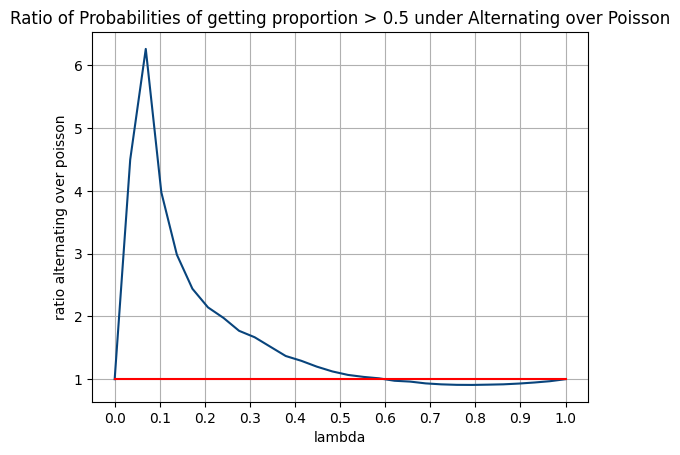

In [10]:
plt.plot(l_lambda, ratio_half, color='#08447c')
plt.plot(l_lambda, ratio_one, color='red')
plt.xticks(np.arange(0,1.1,0.1).tolist())
plt.xlabel('lambda')
plt.ylabel('ratio alternating over poisson')
plt.title('Ratio of Probabilities of getting proportion > 0.5 under Alternating over Poisson')
plt.grid(True)
plt.show()

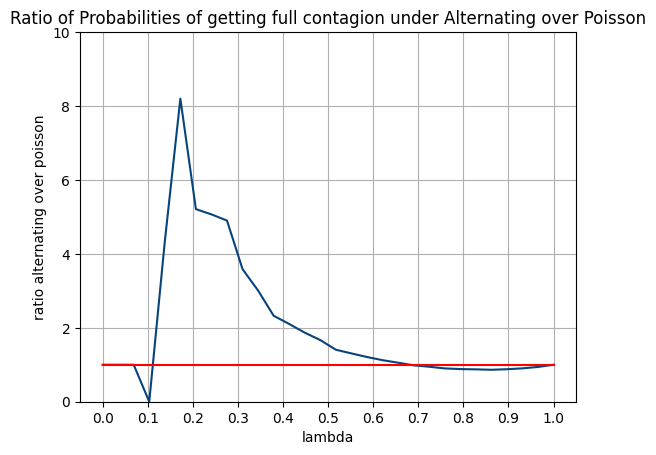

In [11]:
plt.plot(l_lambda, ratio_full, color='#08447c')
plt.plot(l_lambda, ratio_one, color='red')
plt.xticks(np.arange(0,1.1,0.1).tolist())
plt.ylim(0, 10)
plt.xlabel('lambda')
plt.ylabel('ratio alternating over poisson')
plt.title('Ratio of Probabilities of getting full contagion under Alternating over Poisson')
plt.grid(True)
plt.show()

Even though the magnitude of the results changes by running the simulation multiple times, in general from the graph we can see that in areas in which we prefer heterogeneity we get a real boost in the probability to inform, while when we prefer homogeneity, the gains are limited. This shows that the benefits of having an heterogeneous population far outweigh the disadvantages in the cases when we prefer having a homogeneous population. 

#### Simulation 3 - Information Diffusion on Lines of Five Nodes

The objective of this simulation is to demonstrate the effect of various combinations of nodes on the spread of contagion and rank their efficiency in the contagion process. To accomplish this, $50,000$ line graph simulations will be conducted for $30$ distinct values of the parameter $\lambda$ for each combination. In the following code-block, we simulate the combinations *PSPSP*, *PPPPP*, *RSRSR*, *RRRRR*, *SSSSS* and *PRPRP*:

In [12]:
# the 30 values of lambda
l_lambda = np.linspace(0, 1, 30).tolist()

# lists to keep track of the simulations
prob_quarter_pspsp = [0 for i in range(len(l_lambda))]
prob_half_pspsp = [0 for i in range(len(l_lambda))]
prob_quarter_ppppp = [0 for i in range(len(l_lambda))]
prob_half_ppppp = [0 for i in range(len(l_lambda))]
prob_quarter_rsrsr = [0 for i in range(len(l_lambda))]
prob_half_rsrsr = [0 for i in range(len(l_lambda))]
prob_quarter_rrrrr = [0 for i in range(len(l_lambda))]
prob_half_rrrrr = [0 for i in range(len(l_lambda))]
prob_quarter_sssss = [0 for i in range(len(l_lambda))]
prob_half_sssss = [0 for i in range(len(l_lambda))]
prob_quarter_prprp = [0 for i in range(len(l_lambda))]
prob_half_prprp = [0 for i in range(len(l_lambda))]


for time in range(50_000):
    # 50,000 times
    for l in range(len(l_lambda)):
        # generating the nodes in the right order
        pspsp = [Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        ppppp = [Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        rsrsr = [Reversing([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Reversing([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Reversing([], l_lambda[l], 2)]
        rrrrr = [Reversing([], l_lambda[l], 2), Reversing([], l_lambda[l], 2), Reversing([], l_lambda[l], 2), Reversing([], l_lambda[l], 2), Reversing([], l_lambda[l], 2)]
        sssss = [Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        prprp = [Poisson([], l_lambda[l], 2), Reversing([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Reversing([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]

        # assembling the line
        pspsp = assemble_line(pspsp)
        ppppp = assemble_line(ppppp)
        rsrsr = assemble_line(rsrsr)
        rrrrr = assemble_line(rrrrr)
        sssss = assemble_line(sssss)
        prprp = assemble_line(prprp)

        # simulating the infection
        infection(pspsp, start_process_ends(pspsp), 0)
        infection(ppppp, start_process_ends(ppppp), 0)
        infection(rsrsr, start_process_ends(rsrsr), 0)
        infection(rrrrr, start_process_ends(rrrrr), 0)
        infection(sssss, start_process_ends(sssss), 0)
        infection(prprp, start_process_ends(prprp), 0)

        # count > 25% infected and > 50% infected
        count_pspsp = 0
        count_ppppp = 0
        count_rsrsr = 0
        count_rrrrr = 0
        count_sssss = 0
        count_prprp = 0
        for i in range(5):
            if pspsp[i].disease:
                count_pspsp += 1
            if ppppp[i].disease:
                count_ppppp += 1
            if rsrsr[i].disease:
                count_rsrsr += 1
            if rrrrr[i].disease:
                count_rrrrr += 1
            if sssss[i].disease:
                count_sssss += 1
            if prprp[i].disease:
                count_prprp += 1
        
        if count_pspsp/5 > 0.25:
            prob_quarter_pspsp[l] += 1
        if count_ppppp/5 > 0.25:
            prob_quarter_ppppp[l] += 1
        if count_rsrsr/5 > 0.25:
            prob_quarter_rsrsr[l] += 1
        if count_rrrrr/5 > 0.25:
            prob_quarter_rrrrr[l] += 1
        if count_sssss/5 > 0.25:
            prob_quarter_sssss[l] += 1
        if count_prprp/5 > 0.25:
            prob_quarter_prprp[l] += 1

        if count_pspsp/5 > 0.5:
            prob_half_pspsp[l] += 1
        if count_ppppp/5 > 0.5:
            prob_half_ppppp[l] += 1
        if count_rsrsr/5 > 0.5:
            prob_half_rsrsr[l] += 1
        if count_rrrrr/5 > 0.5:
            prob_half_rrrrr[l] += 1
        if count_sssss/5 > 0.5:
            prob_half_sssss[l] += 1
        if count_prprp/5 > 0.5:
            prob_half_prprp[l] += 1

The probability of events is calculated by dividing the number of cases that occurred by the number of possible cases

In [13]:
# calculating the probability
prob_quarter_pspsp = [x/50_000 for x in prob_quarter_pspsp]
prob_half_pspsp = [x/50_000 for x in prob_half_pspsp]
prob_quarter_ppppp = [x/50_000 for x in prob_quarter_ppppp]
prob_half_ppppp = [x/50_000 for x in prob_half_ppppp]
prob_quarter_rsrsr = [x/50_000 for x in prob_quarter_rsrsr]
prob_half_rsrsr = [x/50_000 for x in prob_half_rsrsr]
prob_quarter_rrrrr = [x/50_000 for x in prob_quarter_rrrrr]
prob_half_rrrrr = [x/50_000 for x in prob_half_rrrrr]
prob_quarter_sssss = [x/50_000 for x in prob_quarter_sssss]
prob_half_sssss = [x/50_000 for x in prob_half_sssss]
prob_quarter_prprp = [x/50_000 for x in prob_quarter_prprp]
prob_half_prprp = [x/50_000 for x in prob_half_prprp]

The resulting curves for the different combinations are:

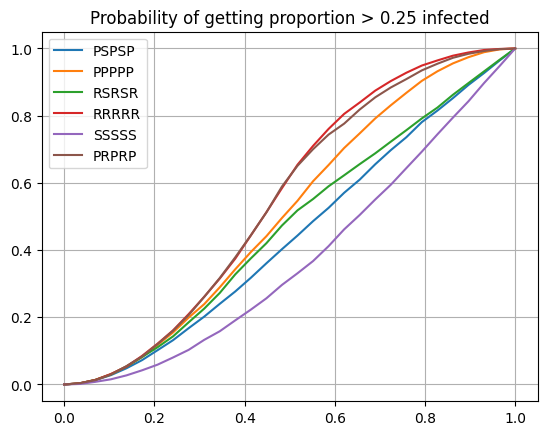

In [14]:
# plotting
plt.plot(l_lambda, prob_quarter_pspsp, label='PSPSP')
plt.plot(l_lambda, prob_quarter_ppppp, label='PPPPP')
plt.plot(l_lambda, prob_quarter_rsrsr, label='RSRSR')
plt.plot(l_lambda, prob_quarter_rrrrr, label='RRRRR')
plt.plot(l_lambda, prob_quarter_sssss, label='SSSSS')
plt.plot(l_lambda, prob_quarter_prprp, label='PRPRP')

plt.title('Probability of getting proportion > 0.25 infected')
plt.grid(True)
plt.legend()
plt.show()

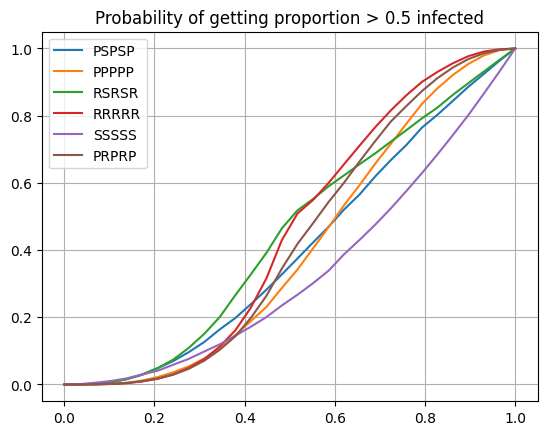

In [15]:
# plotting
plt.plot(l_lambda, prob_half_pspsp, label='PSPSP')
plt.plot(l_lambda, prob_half_ppppp, label='PPPPP')
plt.plot(l_lambda, prob_half_rsrsr, label='RSRSR')
plt.plot(l_lambda, prob_half_rrrrr, label='RRRRR')
plt.plot(l_lambda, prob_half_sssss, label='SSSSS')
plt.plot(l_lambda, prob_half_prprp, label='PRPRP')

plt.title('Probability of getting proportion > 0.5 infected')
plt.grid(True)
plt.legend()
plt.show()

The results of the simulation matches the ones of the paper.

#### Simulation 4 - Diffusion of Information in Erdos-Renyi Random Networks 

The purpose of this simulation is to investigate the impact of various node configurations on the spread of contagion in a society. To achieve this, an Erdos-Renyi graph is utilized with a probability of $25%$ for the formation of links. Additionally, the results are obtained by analyzing $50,000$ instances of the simulation for $30$ different values of $\lambda$ for each node configuration.

In [ ]:
def erdos_renyi(p, nodes):  
    """
    This function generates a random graph using the Erdos-Renyi method starting from a given set of nodes.

    Parameters:
        p (float): probability of an edge
        nodes (list): list of ordered nodes

    Returns:
        list: an Erdos-Renyi random graph
    """  
    for node1 in nodes:
        for node2 in nodes:
            if node1 == node2:
                continue
            else:
                if random.random() < p:
                    node1.edges += [node2]
                    node2.edges += [node1]
    
    return nodes

In [ ]:
# 30 values of lambda
l_lambda = np.linspace(0, 1, 30).tolist()

# to hold the amount of cases for 25% and 50% of contagion
prob_quarter_erps = [0 for i in range(len(l_lambda))]
prob_half_erps = [0 for i in range(len(l_lambda))]
prob_quarter_erpp = [0 for i in range(len(l_lambda))]
prob_half_erpp = [0 for i in range(len(l_lambda))]
prob_quarter_errs = [0 for i in range(len(l_lambda))]
prob_half_errs = [0 for i in range(len(l_lambda))]
prob_quarter_errr = [0 for i in range(len(l_lambda))]
prob_half_errr = [0 for i in range(len(l_lambda))]
prob_quarter_erss = [0 for i in range(len(l_lambda))]
prob_half_erss = [0 for i in range(len(l_lambda))]
prob_quarter_erpr = [0 for i in range(len(l_lambda))]
prob_half_erpr = [0 for i in range(len(l_lambda))]


for time in range(50_000):
    for l in range(len(l_lambda)):

        # generating the nodes
        erps = [Poisson([], l_lambda[l], 2) for i in range(20)] + [Sticky([], l_lambda[l], 2) for i in range(20)]
        erpp = [Poisson([], l_lambda[l], 2) for i in range(40)]
        errs = [Reversing([], l_lambda[l], 2) for i in range(20)] + [Sticky([], l_lambda[l], 2) for i in range(20)]
        errr = [Reversing([], l_lambda[l], 2) for i in range(40)]
        erss = [Sticky([], l_lambda[l], 2) for i in range(40)]
        erpr = [Poisson([], l_lambda[l], 2) for i in range(20)] + [Reversing([], l_lambda[l], 2) for i in range(20)]

        # generating random graph
        erdos_renyi(0.25, erps)
        erdos_renyi(0.25, erpp)
        erdos_renyi(0.25, errs)
        erdos_renyi(0.25, errr)
        erdos_renyi(0.25, erss)
        erdos_renyi(0.25, erpr)

        # simulating the infection
        infection(erps, start_process_random(erps), 0)
        infection(erpp, start_process_random(erpp), 0)
        infection(errs, start_process_random(errs), 0)
        infection(errr, start_process_random(errr), 0)
        infection(erss, start_process_random(erss), 0)
        infection(erpr, start_process_random(erpr), 0)

        # count > 25% infected and > 50% infected
        count_erps = 0
        count_erpp = 0
        count_errs = 0
        count_errr = 0
        count_erss = 0
        count_erpr = 0
        for i in range(5):
            if erps[i].disease:
                count_erps += 1
            if erpp[i].disease:
                count_erpp += 1
            if errs[i].disease:
                count_errs += 1
            if errr[i].disease:
                count_errr += 1
            if erss[i].disease:
                count_erss += 1
            if erpr[i].disease:
                count_erpr += 1
        
        if count_erps/5 > 0.25:
            prob_quarter_erps[l] += 1
        if count_erpp/5 > 0.25:
            prob_quarter_erpp[l] += 1
        if count_errs/5 > 0.25:
            prob_quarter_errs[l] += 1
        if count_errr/5 > 0.25:
            prob_quarter_errr[l] += 1
        if count_erss/5 > 0.25:
            prob_quarter_erss[l] += 1
        if count_erpr/5 > 0.25:
            prob_quarter_erpr[l] += 1

        if count_erps/5 > 0.5:
            prob_half_erps[l] += 1
        if count_erpp/5 > 0.5:
            prob_half_erpp[l] += 1
        if count_errs/5 > 0.5:
            prob_half_errs[l] += 1
        if count_errr/5 > 0.5:
            prob_half_errr[l] += 1
        if count_erss/5 > 0.5:
            prob_half_erss[l] += 1
        if count_erpr/5 > 0.5:
            prob_half_erpr[l] += 1

The probability of events is calculated by dividing the number of cases that occurred by the number of possible cases

In [ ]:
prob_quarter_erps = [x/50_000 for x in prob_quarter_erps]
prob_half_erps = [x/50_000 for x in prob_half_erps]
prob_quarter_erpp = [x/50_000 for x in prob_quarter_erpp]
prob_half_erpp = [x/50_000 for x in prob_half_erpp]
prob_quarter_errs = [x/50_000 for x in prob_quarter_errs]
prob_half_errs = [x/50_000 for x in prob_half_errs]
prob_quarter_errr = [x/50_000 for x in prob_quarter_errr]
prob_half_errr = [x/50_000 for x in prob_half_errr]
prob_quarter_erss = [x/50_000 for x in prob_quarter_erss]
prob_half_erss = [x/50_000 for x in prob_half_erss]
prob_quarter_erpr = [x/50_000 for x in prob_quarter_erpr]
prob_half_erpr = [x/50_000 for x in prob_half_erpr]

The resulting curves for the different combinations are:

In [ ]:
plt.plot(l_lambda, prob_quarter_erps, label='P and S')
plt.plot(l_lambda, prob_quarter_erpp, label='P')
plt.plot(l_lambda, prob_quarter_errs, label='R and S')
plt.plot(l_lambda, prob_quarter_errr, label='R')
plt.plot(l_lambda, prob_quarter_erss, label='S')
plt.plot(l_lambda, prob_quarter_erpr, label='P and R')

plt.title('Probability of getting proportion > 0.25 infected')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
plt.plot(l_lambda, prob_half_erps, label='P and S')
plt.plot(l_lambda, prob_half_erpp, label='P')
plt.plot(l_lambda, prob_half_errs, label='R and S')
plt.plot(l_lambda, prob_half_errr, label='R')
plt.plot(l_lambda, prob_half_erss, label='S')
plt.plot(l_lambda, prob_half_erpr, label='P and R')

plt.title('Probability of getting proportion > 0.5 infected')
plt.grid(True)
plt.legend()
plt.show()

The results of the simulation matches the ones of the paper.

## Diffusion of Rumours
This section supports the theoretical claims about the spread of rumours.

In this block, we model the spread of a rumour in a network of nodes. Some nodes are designated as "spreaders", meaning that they actively spread the rumour, while other nodes are "debunkers", meaning that they are aware that the rumour is false and, as soon as they are aware of it, begin to refute it.

The activity patterns of the nodes in this simulation are based on the contagion model presented in other simulations, with the options of Sticky, Poisson, and Reversing patterns. 

In the next simulations, we will observe the spread of the rumour through networks and the role that spreaders and debunkers play in the process. The goal is to understand whether or not we can have the same conclusions as for the simple contagion process.

The rumour is represented by two boolean values. If the node has not heard the rumour and is not a debunker, both the attributes *disease* and *debunker* assume the value **False**. When a node hear for the first time the rumour, the attribute *disease* changes to **True** and, depending on the activity level, the node starts spreading it to its active neighbours. When the debunking process starts, the attribute *debunker* assumes the value **True**, while the attribute *disease* the value **False**. This ensures that we can always track correctly the contagion process at every step. The update of the status of a node is done with the following function:

In [4]:
def rumour(graph, spreaders, debunkers):
    """
    This recursive function simulate a rumour spreading in a network of nodes in which some nodes are able to debunk the information circulating

    Parameters:
        graph (list): the graph for running the simulation
        spreaders (list): list of all current spreaders
        debunkers (list): list of all current debunkers

    Returns:
        list: the graph
    """
    
    # stopping case
    if len(spreaders) == 0 and len(debunkers) == 0:
        return graph

    next_spreaders = []
    next_debunkers = []
    # when there are no current debunkers
    if len(debunkers) == 0:
        for spreader in spreaders:
            # active spreader
            if spreader.status:
                for receiver in spreader.edges: # check all neighbours
                    if receiver.status and not receiver.disease: # active receiver not yet infected
                        # not a debunker
                        if not receiver.debunker:
                            receiver.disease = True
                            next_spreaders.append(receiver)
                        # if it is a debunker
                        else:
                            # becomes a new debunker only it was not debunking before
                            if receiver.debunking_turns == 0:
                                next_debunkers.append(receiver)

            # check if the spreader should still spread next turn
            if spreader.infected_turns < spreader.c_time - 1:
                spreader.infected_turns += 1
                next_spreaders.append(spreader)

        # update status for every node
        for node in graph:
            node.update_status()
        
        # recursive call
        return rumour(graph, next_spreaders, next_debunkers)

    # when there are no current spreaders
    if len(spreaders) == 0:
        for debunker in debunkers:
            # active debunker
            if debunker.status:
                for receiver in debunker.edges: # check all neighbours
                    if receiver.status and not receiver.debunker: # inform the node
                        receiver.debunker = True
                        receiver.disease = False # if it was not infected does not change
                        next_debunkers.append(receiver)
                    
            # check if the debunker should still debunk next turn
            if debunker.debunking_turns < debunker.c_time - 1:
                debunker.debunking_turns += 1
                next_debunkers.append(debunker)

        # update status for every node
        for node in graph:
            node.update_status()

        # recursive call
        return rumour(graph, next_spreaders, next_debunkers)

    # when the process is mixed
    else:
        # carry the procedure until every node was evaluated
        randomized_action_nodes = spreaders + debunkers
        random.shuffle(randomized_action_nodes)
        
        for node in randomized_action_nodes:
            # if debunker
            if node.debunker:
                # active debunker
                if node.status:
                    for receiver in node.edges: # check all neighbours
                        if receiver.status and not receiver.debunker: # inform the receiver
                            receiver.debunker = True
                            receiver.disease = False # if it was not infected does not change
                            next_debunkers.append(receiver)

                # check if debunker should still debunk next turn
                if node.debunking_turns < node.c_time - 1:
                    node.debunking_turns += 1
                    next_debunkers.append(node)

            # if spreader that was not convinced during this turn
            if node.disease:
                # active spreader
                if node.status:
                    for receiver in node.edges: # check all neighbours
                        if receiver.status and not receiver.disease: # if the receiver is active and not yet infected
                            # if it is not a debunker
                            if not receiver.debunker:
                                receiver.disease = True
                                next_spreaders.append(receiver)

                            # if it is a debunker
                            else:
                                # become a debunker only if was not a debunker before
                                if receiver.debunking_turns == 0:
                                    next_debunkers.append(receiver)

                # check if spreader should still spread next turn
                if node.infected_turns < node.c_time - 1:
                    node.infected_turns += 1
                    next_spreaders.append(node)

        # update the status for every node
        for node in graph:
            node.update_status()

        # check if some spreader got convinced by a debunker (happens when the node contaminate someone and still has time but then gets converted)
        convinced = []
        next_spreaders_noconv = []
        for i in range(len(next_spreaders)):
            if not next_spreaders[i].disease:
                convinced.append(i)
    
        if len(convinced) != 0:
            for i in range(len(convinced)):
                if i not in convinced:
                    next_spreaders_noconv.append(next_spreaders[i])

            return rumour(graph, next_spreaders_noconv, next_debunkers)

        # recursive call
        else:
            return rumour(graph, next_spreaders, next_debunkers)

The next functions will also be used in this section:

In [5]:
def infection(graph, contagious, t):
    """
    This recursive function does the infection process.

    Parameters:
        graph (list): the list of nodes already linked
        contagious (list): the list containing the contagious nodes
        t (int): current time

    Returns:
        list: the same graph after the infection process has finished
        list: a list with the still contagious nodes
        int: the time in which the infection stopped
    """
    # stopping case
    if len(contagious) == 0:
        return graph
    
    else:
        # infection process
        next_turn = []
        for node in contagious:
            # cases where the contagious node is not active
            if not node.status:
                # evaluating if the node should remain contagious
                if node.infected_turns < node.c_time - 1: # if the node has still some turns where it is contagious, add it to the next turn
                    node.infected_turns += 1
                    next_turn.append(node)
                else: # else just update the turns
                    node.infected_turns +=1

            # cases where the contagious node is active
            else:
                # check its neighbours
                for to_infect in node.edges:
                    if not to_infect.disease: # if the neighbour was not infected
                        if to_infect.status: # if the neighbour is active
                            to_infect.disease = True # infect the neighbour
                            next_turn.append(to_infect) # add it to the next turn

                # evaluating if the node should remain contagious
                if node.infected_turns < node.c_time - 1: # if the node has still some turns where it is contagious
                    node.infected_turns += 1
                    next_turn.append(node)
                else: # else just update the turns
                    node.infected_turns += 1

        # updating procedure
        for node in graph:
            node.update_status()
        
        t += 1
        return infection(graph, next_turn, t)

In [6]:
def assemble_line(nodes):
    """
    This function generates a line graph starting from a set of nodes.

    Parameters:
        nodes (list): list of ordered nodes

    Returns:
        list: a line graph
    """
    flag = 0
    while flag < len(nodes)-1:
        nodes[flag].edges.append(nodes[flag+1])
        nodes[flag+1].edges.append(nodes[flag])
        flag +=1
        
    return nodes

#### Simulation 5 - Rumour Diffusion in Lines of Three Nodes

The goal of this simulation is to verify that the optimal lines of lenght three are *SSS*, *PSP* and *PPP*. Thus, in the following code-block, 50,000 simulations of all the different combinations are performed to compare the normal contagion process to the spread of rumours. First, the probabilities of fully debunk a rumour are calculated:

In [19]:
l_lambda = np.linspace(0, 1, 30).tolist()

# lists to keep track of the simulations
prob_full_sss = [0 for i in range(len(l_lambda))]
prob_full_ssp = [0 for i in range(len(l_lambda))]
prob_full_sps = [0 for i in range(len(l_lambda))]
prob_full_pss = [0 for i in range(len(l_lambda))]
prob_full_spp = [0 for i in range(len(l_lambda))]
prob_full_psp = [0 for i in range(len(l_lambda))]
prob_full_pps = [0 for i in range(len(l_lambda))]
prob_full_ppp = [0 for i in range(len(l_lambda))]

for time in range(50_000):
    for l in range(len(l_lambda)):
        sss = [Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        ssp = [Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        sps = [Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        pss = [Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        spp = [Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        psp = [Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        pps = [Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        ppp = [Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]

        assemble_line(sss)
        assemble_line(ssp)
        assemble_line(sps)
        assemble_line(pss)
        assemble_line(spp)
        assemble_line(psp)
        assemble_line(pps)
        assemble_line(ppp)

        sss[0].disease = True
        sss[-1].debunker = True
        ssp[0].disease = True
        ssp[-1].debunker = True
        sps[0].disease = True
        sps[-1].debunker = True
        pss[0].disease = True
        pss[-1].debunker = True
        spp[0].disease = True
        spp[-1].debunker = True
        psp[0].disease = True
        psp[-1].debunker = True
        pps[0].disease = True
        pps[-1].debunker = True
        ppp[0].disease = True
        ppp[-1].debunker = True

        rumour(sss, [sss[0]], [])
        rumour(ssp, [ssp[0]], [])
        rumour(sps, [sps[0]], [])
        rumour(pss, [pss[0]], [])
        rumour(spp, [spp[0]], [])
        rumour(psp, [psp[0]], [])
        rumour(pps, [pps[0]], [])
        rumour(ppp, [ppp[0]], [])

        count_sss = 0
        count_ssp = 0
        count_sps = 0
        count_pss = 0
        count_spp = 0
        count_psp = 0
        count_pps = 0
        count_ppp = 0
        for i in range(3):
            if sss[i].debunker:
                count_sss += 1
            if ssp[i].debunker:
                count_ssp += 1
            if sps[i].debunker:
                count_sps += 1
            if pss[i].debunker:
                count_pss += 1
            if spp[i].debunker:
                count_spp += 1
            if psp[i].debunker:
                count_psp += 1
            if pps[i].debunker:
                count_pps += 1
            if ppp[i].debunker:
                count_ppp += 1
                
        if count_sss == 3:
            prob_full_sss[l] += 1
        if count_ssp == 3:
            prob_full_ssp[l] += 1
        if count_sps == 3:
            prob_full_sps[l] += 1
        if count_pss == 3:
            prob_full_pss[l] += 1
        if count_spp == 3:
            prob_full_spp[l] += 1
        if count_psp == 3:
            prob_full_psp[l] += 1
        if count_pps == 3:
            prob_full_pps[l] += 1
        if count_ppp == 3:
            prob_full_ppp[l] += 1

In [20]:
# calculating the probability 
prob_full_sss = [x/50_000 for x in prob_full_sss]
prob_full_ssp = [x/50_000 for x in prob_full_ssp]
prob_full_sps = [x/50_000 for x in prob_full_sps]
prob_full_pss = [x/50_000 for x in prob_full_pss]
prob_full_spp = [x/50_000 for x in prob_full_spp]
prob_full_psp = [x/50_000 for x in prob_full_psp]
prob_full_pps = [x/50_000 for x in prob_full_pps]
prob_full_ppp = [x/50_000 for x in prob_full_ppp]

The resulting curves for the different combinations are:

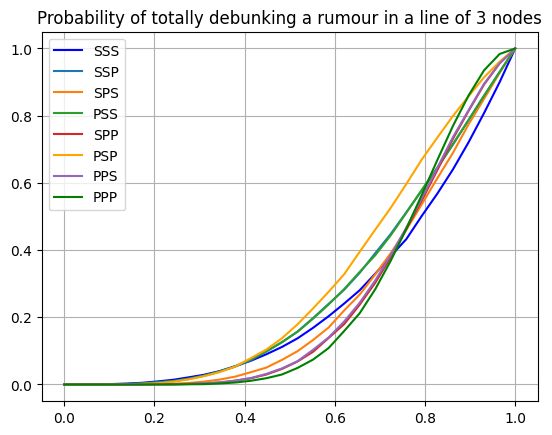

In [21]:
# plotting
plt.plot(l_lambda, prob_full_sss, label='SSS', color='blue')
plt.plot(l_lambda, prob_full_ssp, label='SSP')
plt.plot(l_lambda, prob_full_sps, label='SPS')
plt.plot(l_lambda, prob_full_pss, label='PSS')
plt.plot(l_lambda, prob_full_spp, label='SPP')
plt.plot(l_lambda, prob_full_psp, label='PSP', color='orange')
plt.plot(l_lambda, prob_full_pps, label='PPS')
plt.plot(l_lambda, prob_full_ppp, label='PPP', color='green')

plt.title('Probability of totally debunking a rumour in a line of 3 nodes')
plt.grid(True)
plt.legend()
plt.show()

Focus on the beginning:

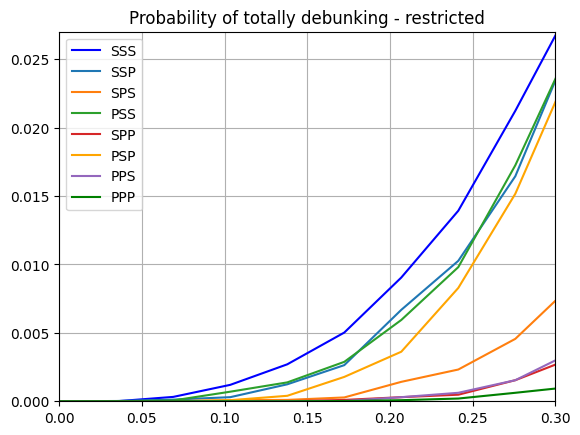

In [22]:
# plotting - restricted
plt.plot(l_lambda, prob_full_sss, label='SSS', color='blue')
plt.plot(l_lambda, prob_full_ssp, label='SSP')
plt.plot(l_lambda, prob_full_sps, label='SPS')
plt.plot(l_lambda, prob_full_pss, label='PSS')
plt.plot(l_lambda, prob_full_spp, label='SPP')
plt.plot(l_lambda, prob_full_psp, label='PSP', color='orange')
plt.plot(l_lambda, prob_full_pps, label='PPS')
plt.plot(l_lambda, prob_full_ppp, label='PPP', color='green')
plt.xlim(0, 0.3)
plt.ylim(0, 0.027)

plt.title('Probability of totally debunking - restricted')
plt.grid(True)
plt.legend()
plt.show()

So the best lines are actually the ones predicted by the theory:

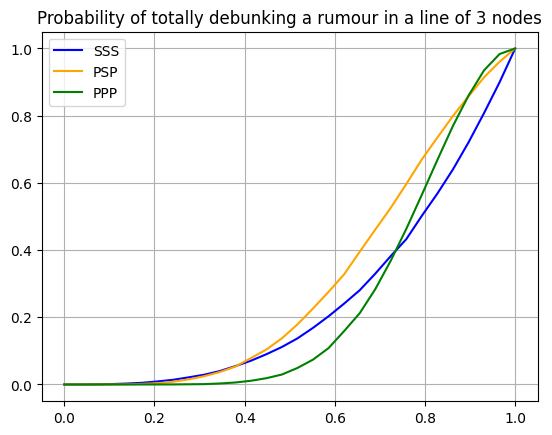

In [23]:
# plotting
plt.plot(l_lambda, prob_full_sss, label='SSS', color='blue')
plt.plot(l_lambda, prob_full_psp, label='PSP', color='orange')
plt.plot(l_lambda, prob_full_ppp, label='PPP', color='green')

plt.title('Probability of totally debunking a rumour in a line of 3 nodes')
plt.grid(True)
plt.legend()
plt.show()

Moreover, $\lambda^*$ and $\lambda^{**}$ are:

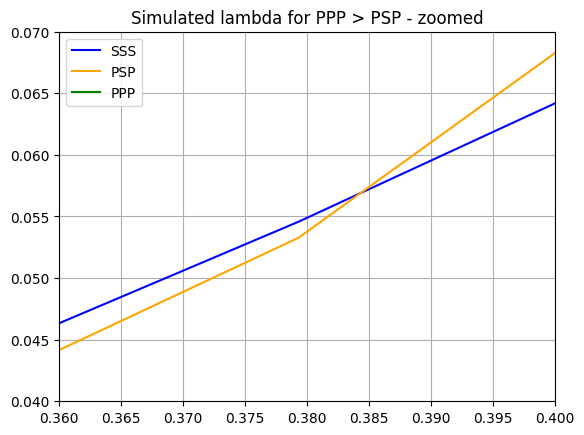

In [27]:
# plotting - restricted
plt.plot(l_lambda, prob_full_sss, label='SSS', color='blue')
plt.plot(l_lambda, prob_full_psp, label='PSP', color='orange')
plt.plot(l_lambda, prob_full_ppp, label='PPP', color='green')
plt.xlim(0.36, 0.4)
plt.ylim(0.04, 0.07)

plt.title('Simulated lambda for PPP > PSP - zoomed')
plt.grid(True)
plt.legend()
plt.show()

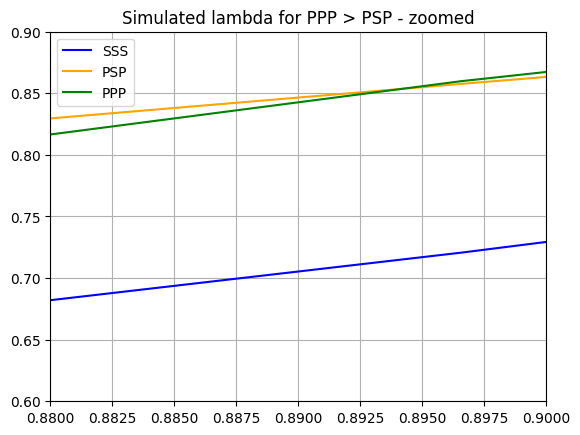

In [28]:
# plotting - restricted
plt.plot(l_lambda, prob_full_sss, label='SSS', color='blue')
plt.plot(l_lambda, prob_full_psp, label='PSP', color='orange')
plt.plot(l_lambda, prob_full_ppp, label='PPP', color='green')
plt.xlim(0.88, 0.9)
plt.ylim(0.6, 0.9)

plt.title('Simulated lambda for PPP > PSP - zoomed')
plt.grid(True)
plt.legend()
plt.show()

For the classical contagion process, we can measure how the contagion spread in the different configurations:

In [29]:
prob_full_sss_c = [0 for i in range(len(l_lambda))]
prob_full_ssp_c = [0 for i in range(len(l_lambda))]
prob_full_sps_c = [0 for i in range(len(l_lambda))]
prob_full_pss_c = [0 for i in range(len(l_lambda))]
prob_full_spp_c = [0 for i in range(len(l_lambda))]
prob_full_psp_c = [0 for i in range(len(l_lambda))]
prob_full_pps_c = [0 for i in range(len(l_lambda))]
prob_full_ppp_c = [0 for i in range(len(l_lambda))]

for time in range(50_000):
    for l in range(len(l_lambda)):
        sss = [Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        ssp = [Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        sps = [Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        pss = [Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        spp = [Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        psp = [Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        pps = [Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        ppp = [Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]

        assemble_line(sss)
        assemble_line(ssp)
        assemble_line(sps)
        assemble_line(pss)
        assemble_line(spp)
        assemble_line(psp)
        assemble_line(pps)
        assemble_line(ppp)

        sss[0].disease = True
        ssp[0].disease = True
        sps[0].disease = True
        pss[0].disease = True
        spp[0].disease = True
        psp[0].disease = True
        pps[0].disease = True
        ppp[0].disease = True

        infection(sss, [sss[0]], 0)
        infection(ssp, [ssp[0]], 0)
        infection(sps, [sps[0]], 0)
        infection(pss, [pss[0]], 0)
        infection(spp, [spp[0]], 0)
        infection(psp, [psp[0]], 0)
        infection(pps, [pps[0]], 0)
        infection(ppp, [ppp[0]], 0)

        count_sss = 0
        count_ssp = 0
        count_sps = 0
        count_pss = 0
        count_spp = 0
        count_psp = 0
        count_pps = 0
        count_ppp = 0
        for i in range(3):
            if sss[i].disease:
                count_sss += 1
            if ssp[i].disease:
                count_ssp += 1
            if sps[i].disease:
                count_sps += 1
            if pss[i].disease:
                count_pss += 1
            if spp[i].disease:
                count_spp += 1
            if psp[i].disease:
                count_psp += 1
            if pps[i].disease:
                count_pps += 1
            if ppp[i].disease:
                count_ppp += 1
                
        if count_sss == 3:
            prob_full_sss_c[l] += 1
        if count_ssp == 3:
            prob_full_ssp_c[l] += 1
        if count_sps == 3:
            prob_full_sps_c[l] += 1
        if count_pss == 3:
            prob_full_pss_c[l] += 1
        if count_spp == 3:
            prob_full_spp_c[l] += 1
        if count_psp == 3:
            prob_full_psp_c[l] += 1
        if count_pps == 3:
            prob_full_pps_c[l] += 1
        if count_ppp == 3:
            prob_full_ppp_c[l] += 1

In [30]:
# calculating the probability (favourable cases/possible cases)
prob_full_sss_c = [x/50_000 for x in prob_full_sss_c]
prob_full_ssp_c = [x/50_000 for x in prob_full_ssp_c]
prob_full_sps_c = [x/50_000 for x in prob_full_sps_c]
prob_full_pss_c = [x/50_000 for x in prob_full_pss_c]
prob_full_spp_c = [x/50_000 for x in prob_full_spp_c]
prob_full_psp_c = [x/50_000 for x in prob_full_psp_c]
prob_full_pps_c = [x/50_000 for x in prob_full_pps_c]
prob_full_ppp_c = [x/50_000 for x in prob_full_ppp_c]

The resulting curves for the different combinations are:

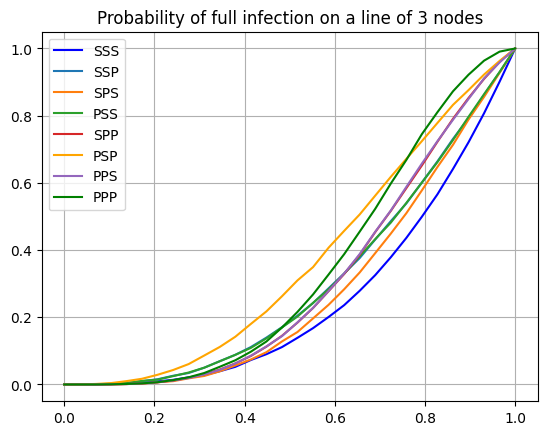

In [31]:
# plotting
plt.plot(l_lambda, prob_full_sss_c, label='SSS', color='blue')
plt.plot(l_lambda, prob_full_ssp_c, label='SSP')
plt.plot(l_lambda, prob_full_sps_c, label='SPS')
plt.plot(l_lambda, prob_full_pss_c, label='PSS')
plt.plot(l_lambda, prob_full_spp_c, label='SPP')
plt.plot(l_lambda, prob_full_psp_c, label='PSP', color='orange')
plt.plot(l_lambda, prob_full_pps_c, label='PPS')
plt.plot(l_lambda, prob_full_ppp_c, label='PPP', color='green')

plt.title('Probability of full infection on a line of 3 nodes')
plt.grid(True)
plt.legend()
plt.show()

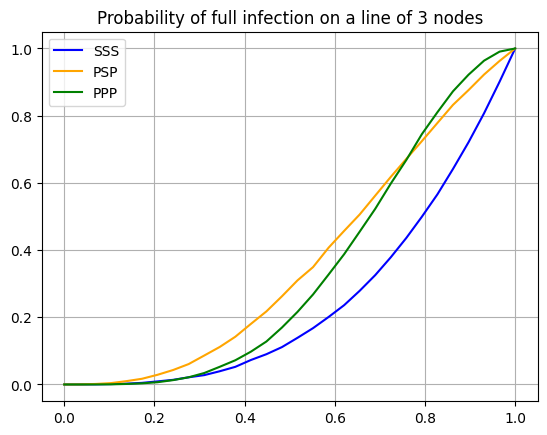

In [32]:
# plotting
plt.plot(l_lambda, prob_full_sss_c, label='SSS', color='blue')
plt.plot(l_lambda, prob_full_psp_c, label='PSP', color='orange')
plt.plot(l_lambda, prob_full_ppp_c, label='PPP', color='green')

plt.title('Probability of full infection on a line of 3 nodes')
plt.grid(True)
plt.legend()
plt.show()

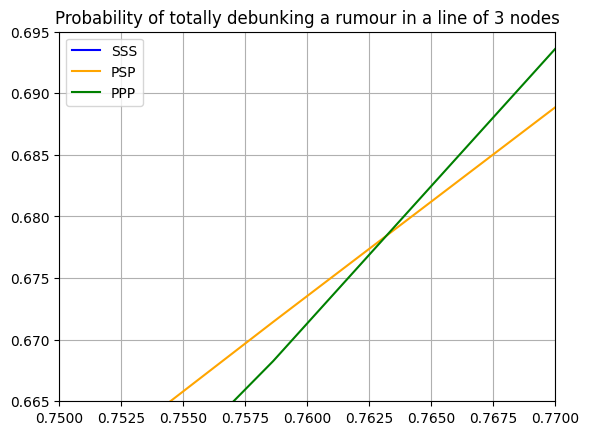

In [34]:
# plotting - restricted
plt.plot(l_lambda, prob_full_sss_c, label='SSS', color='blue')
plt.plot(l_lambda, prob_full_psp_c, label='PSP', color='orange')
plt.plot(l_lambda, prob_full_ppp_c, label='PPP', color='green')
plt.xlim(0.75, 0.77)
plt.ylim(0.665, 0.695)

plt.title('Probability of totally debunking a rumour in a line of 3 nodes')
plt.grid(True)
plt.legend()
plt.show()

So, the rumour had an effect only on the level of $\lambda$ and not on the optimal configurations.

#### Simulation 6 - Rumour Diffusion in Lines of Five Nodes

The goal of this simulation is to verify that the optimal lines of any lenght are *SSS...SSS*, *PSS...SSP*, *PSP...PSP* and *PPP...PPP*. Because we cannot test lines of infinite lenght, we will use lines with five agents so that we can test the presence of *PSSSP*. In the next code-block we test every combination of five nodes using *sticky* and *poisson* nodes:

In [40]:
# the 30 values of lambda
l_lambda = np.linspace(0, 1, 30).tolist()

# lists to keep track of the simulations
prob_ppppp = [0 for i in range(len(l_lambda))]
prob_pppps = [0 for i in range(len(l_lambda))]
prob_pppsp = [0 for i in range(len(l_lambda))]
prob_pppss = [0 for i in range(len(l_lambda))]
prob_ppspp = [0 for i in range(len(l_lambda))]
prob_ppsps = [0 for i in range(len(l_lambda))]
prob_ppssp = [0 for i in range(len(l_lambda))]
prob_ppsss = [0 for i in range(len(l_lambda))]
prob_psppp = [0 for i in range(len(l_lambda))]
prob_pspps = [0 for i in range(len(l_lambda))]
prob_pspsp = [0 for i in range(len(l_lambda))]
prob_pspss = [0 for i in range(len(l_lambda))]
prob_psspp = [0 for i in range(len(l_lambda))]
prob_pssps = [0 for i in range(len(l_lambda))]
prob_psssp = [0 for i in range(len(l_lambda))]
prob_pssss = [0 for i in range(len(l_lambda))]
prob_spppp = [0 for i in range(len(l_lambda))]
prob_sppps = [0 for i in range(len(l_lambda))]
prob_sppsp = [0 for i in range(len(l_lambda))]
prob_sppss = [0 for i in range(len(l_lambda))]
prob_spspp = [0 for i in range(len(l_lambda))]
prob_spsps = [0 for i in range(len(l_lambda))]
prob_spssp = [0 for i in range(len(l_lambda))]
prob_spsss = [0 for i in range(len(l_lambda))]
prob_ssppp = [0 for i in range(len(l_lambda))]
prob_sspps = [0 for i in range(len(l_lambda))]
prob_sspsp = [0 for i in range(len(l_lambda))]
prob_sspss = [0 for i in range(len(l_lambda))]
prob_ssspp = [0 for i in range(len(l_lambda))]
prob_sssps = [0 for i in range(len(l_lambda))]
prob_ssssp = [0 for i in range(len(l_lambda))]
prob_sssss = [0 for i in range(len(l_lambda))]

for time in range(50_000):
    # 50,000 times
    for l in range(len(l_lambda)):
        # generating the nodes in the right order
        ppppp = [Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        pppps = [Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        pppsp = [Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        pppss = [Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        ppspp = [Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        ppsps = [Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        ppssp = [Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        ppsss = [Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        psppp = [Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        pspps = [Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        pspsp = [Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        pspss = [Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        psspp = [Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        pssps = [Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        psssp = [Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        pssss = [Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        spppp = [Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        sppps = [Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        sppsp = [Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        sppss = [Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        spspp = [Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        spsps = [Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        spssp = [Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        spsss = [Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        ssppp = [Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        sspps = [Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        sspsp = [Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        sspss = [Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        ssspp = [Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        sssps = [Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        ssssp = [Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        sssss = [Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]

        # assembling the line
        ppppp = assemble_line(ppppp)
        pppps = assemble_line(pppps)
        pppsp = assemble_line(pppsp)
        pppss = assemble_line(pppss)
        ppspp = assemble_line(ppspp)
        ppsps = assemble_line(ppsps)
        ppssp = assemble_line(ppssp)
        ppsss = assemble_line(ppsss)
        psppp = assemble_line(psppp)
        pspps = assemble_line(pspps)
        pspsp = assemble_line(pspsp)
        pspss = assemble_line(pspss)
        psspp = assemble_line(psspp)
        pssps = assemble_line(pssps)
        psssp = assemble_line(psssp)
        pssss = assemble_line(pssss)
        spppp = assemble_line(spppp)
        sppps = assemble_line(sppps)
        sppsp = assemble_line(sppsp)
        sppss = assemble_line(sppss)
        spspp = assemble_line(spspp)
        spsps = assemble_line(spsps)
        spssp = assemble_line(spssp)
        spsss = assemble_line(spsss)
        ssppp = assemble_line(ssppp)
        sspps = assemble_line(sspps)
        sspsp = assemble_line(sspsp)
        sspss = assemble_line(sspss)
        ssspp = assemble_line(ssspp)
        sssps = assemble_line(sssps)
        ssssp = assemble_line(ssssp)
        sssss = assemble_line(sssss)

        # starting the infection
        ppppp[0].disease = True
        pppps[0].disease = True
        pppsp[0].disease = True
        pppss[0].disease = True
        ppspp[0].disease = True
        ppsps[0].disease = True
        ppssp[0].disease = True
        ppsss[0].disease = True
        psppp[0].disease = True
        pspps[0].disease = True
        pspsp[0].disease = True
        pspss[0].disease = True
        psspp[0].disease = True
        pssps[0].disease = True
        psssp[0].disease = True
        pssss[0].disease = True
        spppp[0].disease = True
        sppps[0].disease = True
        sppsp[0].disease = True
        sppss[0].disease = True
        spspp[0].disease = True
        spsps[0].disease = True
        spssp[0].disease = True
        spsss[0].disease = True
        ssppp[0].disease = True
        sspps[0].disease = True
        sspsp[0].disease = True
        sspss[0].disease = True
        ssspp[0].disease = True
        sssps[0].disease = True
        ssssp[0].disease = True
        sssss[0].disease = True

        # assigning debunkers
        ppppp[-1].debunker = True
        pppps[-1].debunker = True
        pppsp[-1].debunker = True
        pppss[-1].debunker = True
        ppspp[-1].debunker = True
        ppsps[-1].debunker = True
        ppssp[-1].debunker = True
        ppsss[-1].debunker = True
        psppp[-1].debunker = True
        pspps[-1].debunker = True
        pspsp[-1].debunker = True
        pspss[-1].debunker = True
        psspp[-1].debunker = True
        pssps[-1].debunker = True
        psssp[-1].debunker = True
        pssss[-1].debunker = True
        spppp[-1].debunker = True
        sppps[-1].debunker = True
        sppsp[-1].debunker = True
        sppss[-1].debunker = True
        spspp[-1].debunker = True
        spsps[-1].debunker = True
        spssp[-1].debunker = True
        spsss[-1].debunker = True
        ssppp[-1].debunker = True
        sspps[-1].debunker = True
        sspsp[-1].debunker = True
        sspss[-1].debunker = True
        ssspp[-1].debunker = True
        sssps[-1].debunker = True
        ssssp[-1].debunker = True
        sssss[-1].debunker = True

        # simulating the rumour
        rumour(ppppp, [ppppp[0]], [])
        rumour(pppps, [pppps[0]], [])
        rumour(pppsp, [pppsp[0]], [])
        rumour(pppss, [pppss[0]], [])
        rumour(ppspp, [ppspp[0]], [])
        rumour(ppsps, [ppsps[0]], [])
        rumour(ppssp, [ppssp[0]], [])
        rumour(ppsss, [ppsss[0]], [])
        rumour(psppp, [psppp[0]], [])
        rumour(pspps, [pspps[0]], [])
        rumour(pspsp, [pspsp[0]], [])
        rumour(pspss, [pspss[0]], [])
        rumour(psspp, [psspp[0]], [])
        rumour(pssps, [pssps[0]], [])
        rumour(psssp, [psssp[0]], [])
        rumour(pssss, [pssss[0]], [])
        rumour(spppp, [spppp[0]], [])
        rumour(sppps, [sppps[0]], [])
        rumour(sppsp, [sppsp[0]], [])
        rumour(sppss, [sppss[0]], [])
        rumour(spspp, [spspp[0]], [])
        rumour(spsps, [spsps[0]], [])
        rumour(spssp, [spssp[0]], [])
        rumour(spsss, [spsss[0]], [])
        rumour(ssppp, [ssppp[0]], [])
        rumour(sspps, [sspps[0]], [])
        rumour(sspsp, [sspsp[0]], [])
        rumour(sspss, [sspss[0]], [])
        rumour(ssspp, [ssspp[0]], [])
        rumour(sssps, [sssps[0]], [])
        rumour(ssssp, [ssssp[0]], [])
        rumour(sssss, [sssss[0]], [])

        # count full infections
        count_ppppp = 0
        count_pppps = 0
        count_pppsp = 0
        count_pppss = 0
        count_ppspp = 0
        count_ppsps = 0
        count_ppssp = 0
        count_ppsss = 0
        count_psppp = 0
        count_pspps = 0
        count_pspsp = 0
        count_pspss = 0
        count_psspp = 0
        count_pssps = 0
        count_psssp = 0
        count_pssss = 0
        count_spppp = 0
        count_sppps = 0
        count_sppsp = 0
        count_sppss = 0
        count_spspp = 0
        count_spsps = 0
        count_spssp = 0
        count_spsss = 0
        count_ssppp = 0
        count_sspps = 0
        count_sspsp = 0
        count_sspss = 0
        count_ssspp = 0
        count_sssps = 0
        count_ssssp = 0
        count_sssss = 0
        for i in range(5):
            if ppppp[i].debunker:
                count_ppppp += 1
            if pppps[i].debunker:
                count_pppps += 1
            if pppsp[i].debunker:
                count_pppsp += 1
            if pppss[i].debunker:
                count_pppss += 1
            if ppspp[i].debunker:
                count_ppspp += 1
            if ppsps[i].debunker:
                count_ppsps += 1
            if ppssp[i].debunker:
                count_ppssp += 1
            if ppsss[i].debunker:
                count_ppsss += 1
            if psppp[i].debunker:
                count_psppp += 1
            if pspps[i].debunker:
                count_pspps += 1
            if pspsp[i].debunker:
                count_pspsp += 1
            if pspss[i].debunker:
                count_pspss += 1
            if psspp[i].debunker:
                count_psspp += 1
            if pssps[i].debunker:
                count_pssps += 1
            if psssp[i].debunker:
                count_psssp += 1
            if pssss[i].debunker:
                count_pssss += 1
            if spppp[i].debunker:
                count_spppp += 1
            if sppps[i].debunker:
                count_sppps += 1
            if sppsp[i].debunker:
                count_sppsp += 1
            if sppss[i].debunker:
                count_sppss += 1
            if spspp[i].debunker:
                count_spspp += 1
            if spsps[i].debunker:
                count_spsps += 1
            if spssp[i].debunker:
                count_spssp += 1
            if spsss[i].debunker:
                count_spsss += 1
            if ssppp[i].debunker:
                count_ssppp += 1
            if sspps[i].debunker:
                count_sspps += 1
            if sspsp[i].debunker:
                count_sspsp += 1
            if sspss[i].debunker:
                count_sspss += 1
            if ssspp[i].debunker:
                count_ssspp += 1
            if sssps[i].debunker:
                count_sssps += 1
            if ssssp[i].debunker:
                count_ssssp += 1
            if sssss[i].debunker:
                count_sssss += 1

        if count_ppppp == 5:
                prob_ppppp[l] += 1
        if count_pppps == 5:
                prob_pppps[l] += 1
        if count_pppsp == 5:
                prob_pppsp[l] += 1
        if count_pppss == 5:
                prob_pppss[l] += 1
        if count_ppspp == 5:
                prob_ppspp[l] += 1
        if count_ppsps == 5:
                prob_ppsps[l] += 1
        if count_ppssp == 5:
                prob_ppssp[l] += 1
        if count_ppsss == 5:
                prob_ppsss[l] += 1
        if count_psppp == 5:
                prob_psppp[l] += 1
        if count_pspps == 5:
                prob_pspps[l] += 1
        if count_pspsp == 5:
                prob_pspsp[l] += 1
        if count_pspss == 5:
                prob_pspss[l] += 1
        if count_psspp == 5:
                prob_psspp[l] += 1
        if count_pssps == 5:
                prob_pssps[l] += 1
        if count_psssp == 5:
                prob_psssp[l] += 1
        if count_pssss == 5:
                prob_pssss[l] += 1
        if count_spppp == 5:
                prob_spppp[l] += 1
        if count_sppps == 5:
                prob_sppps[l] += 1
        if count_sppsp == 5:
                prob_sppsp[l] += 1
        if count_sppss == 5:
                prob_sppss[l] += 1
        if count_spspp == 5:
                prob_spspp[l] += 1
        if count_spsps == 5:
                prob_spsps[l] += 1
        if count_spssp == 5:
                prob_spssp[l] += 1
        if count_spsss == 5:
                prob_spsss[l] += 1
        if count_ssppp == 5:
                prob_ssppp[l] += 1
        if count_sspps == 5:
                prob_sspps[l] += 1
        if count_sspsp == 5:
                prob_sspsp[l] += 1
        if count_sspss == 5:
                prob_sspss[l] += 1
        if count_ssspp == 5:
                prob_ssspp[l] += 1
        if count_sssps == 5:
                prob_sssps[l] += 1
        if count_ssssp == 5:
                prob_ssssp[l] += 1
        if count_sssss == 5:
                prob_sssss[l] += 1

In [41]:
prob_ppppp = [x/50_000 for x in prob_ppppp]
prob_pppps = [x/50_000 for x in prob_pppps]
prob_pppsp = [x/50_000 for x in prob_pppsp]
prob_pppss = [x/50_000 for x in prob_pppss]
prob_ppspp = [x/50_000 for x in prob_ppspp]
prob_ppsps = [x/50_000 for x in prob_ppsps]
prob_ppssp = [x/50_000 for x in prob_ppssp]
prob_ppsss = [x/50_000 for x in prob_ppsss]
prob_psppp = [x/50_000 for x in prob_psppp]
prob_pspps = [x/50_000 for x in prob_pspps]
prob_pspsp = [x/50_000 for x in prob_pspsp]
prob_pspss = [x/50_000 for x in prob_pspss]
prob_psspp = [x/50_000 for x in prob_psspp]
prob_pssps = [x/50_000 for x in prob_pssps]
prob_psssp = [x/50_000 for x in prob_psssp]
prob_pssss = [x/50_000 for x in prob_pssss]
prob_spppp = [x/50_000 for x in prob_spppp]
prob_sppps = [x/50_000 for x in prob_sppps]
prob_sppsp = [x/50_000 for x in prob_sppsp]
prob_sppss = [x/50_000 for x in prob_sppss]
prob_spspp = [x/50_000 for x in prob_spspp]
prob_spsps = [x/50_000 for x in prob_spsps]
prob_spssp = [x/50_000 for x in prob_spssp]
prob_spsss = [x/50_000 for x in prob_spsss]
prob_ssppp = [x/50_000 for x in prob_ssppp]
prob_sspps = [x/50_000 for x in prob_sspps]
prob_sspsp = [x/50_000 for x in prob_sspsp]
prob_sspss = [x/50_000 for x in prob_sspss]
prob_ssspp = [x/50_000 for x in prob_ssspp]
prob_sssps = [x/50_000 for x in prob_sssps]
prob_ssssp = [x/50_000 for x in prob_ssssp]
prob_sssss = [x/50_000 for x in prob_sssss]

The resulting curves for the different combinations are:

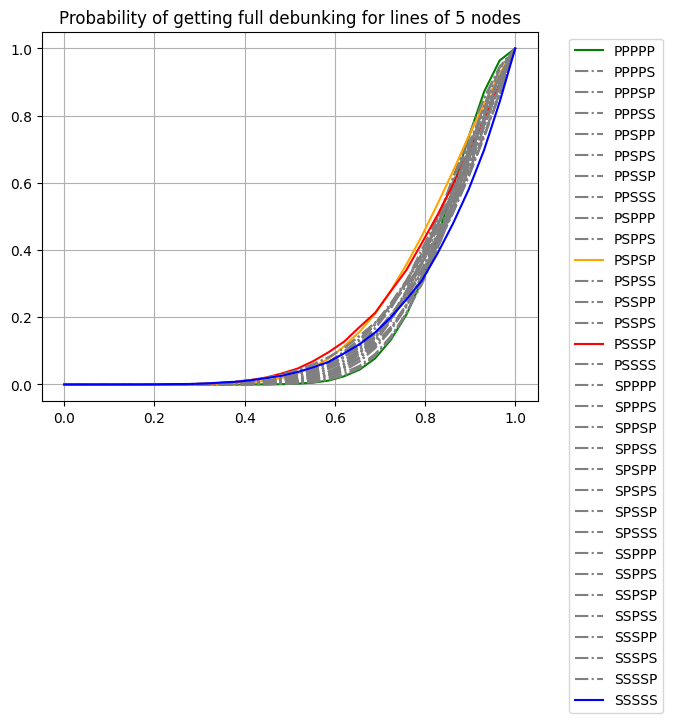

In [42]:
plt.plot(l_lambda, prob_ppppp, label='PPPPP', color='green')
plt.plot(l_lambda, prob_pppps, linestyle='-.', label='PPPPS', color='gray')
plt.plot(l_lambda, prob_pppsp, linestyle='-.', label='PPPSP', color='gray')
plt.plot(l_lambda, prob_pppss, linestyle='-.', label='PPPSS', color='gray')
plt.plot(l_lambda, prob_ppspp, linestyle='-.', label='PPSPP', color='gray')
plt.plot(l_lambda, prob_ppsps, linestyle='-.', label='PPSPS', color='gray')
plt.plot(l_lambda, prob_ppssp, linestyle='-.', label='PPSSP', color='gray')
plt.plot(l_lambda, prob_ppsss, linestyle='-.', label='PPSSS', color='gray')
plt.plot(l_lambda, prob_psppp, linestyle='-.', label='PSPPP', color='gray')
plt.plot(l_lambda, prob_pspps, linestyle='-.', label='PSPPS', color='gray')
plt.plot(l_lambda, prob_pspsp, label='PSPSP', color='orange')
plt.plot(l_lambda, prob_pspss, linestyle='-.', label='PSPSS', color='gray')
plt.plot(l_lambda, prob_psspp, linestyle='-.', label='PSSPP', color='gray')
plt.plot(l_lambda, prob_pssps, linestyle='-.', label='PSSPS', color='gray')
plt.plot(l_lambda, prob_psssp, label='PSSSP', color='red')
plt.plot(l_lambda, prob_pssss, linestyle='-.', label='PSSSS', color='gray')
plt.plot(l_lambda, prob_spppp, linestyle='-.', label='SPPPP', color='gray')
plt.plot(l_lambda, prob_sppps, linestyle='-.', label='SPPPS', color='gray')
plt.plot(l_lambda, prob_sppsp, linestyle='-.', label='SPPSP', color='gray')
plt.plot(l_lambda, prob_sppss, linestyle='-.', label='SPPSS', color='gray')
plt.plot(l_lambda, prob_spspp, linestyle='-.', label='SPSPP', color='gray')
plt.plot(l_lambda, prob_spsps, linestyle='-.', label='SPSPS', color='gray')
plt.plot(l_lambda, prob_spssp, linestyle='-.', label='SPSSP', color='gray')
plt.plot(l_lambda, prob_spsss, linestyle='-.', label='SPSSS', color='gray')
plt.plot(l_lambda, prob_ssppp, linestyle='-.', label='SSPPP', color='gray')
plt.plot(l_lambda, prob_sspps, linestyle='-.', label='SSPPS', color='gray')
plt.plot(l_lambda, prob_sspsp, linestyle='-.', label='SSPSP', color='gray')
plt.plot(l_lambda, prob_sspss, linestyle='-.', label='SSPSS', color='gray')
plt.plot(l_lambda, prob_ssspp, linestyle='-.', label='SSSPP', color='gray')
plt.plot(l_lambda, prob_sssps, linestyle='-.', label='SSSPS', color='gray')
plt.plot(l_lambda, prob_ssssp, linestyle='-.', label='SSSSP', color='gray')
plt.plot(l_lambda, prob_sssss, label='SSSSS', color='blue')

plt.title('Probability of getting full debunking for lines of 5 nodes')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

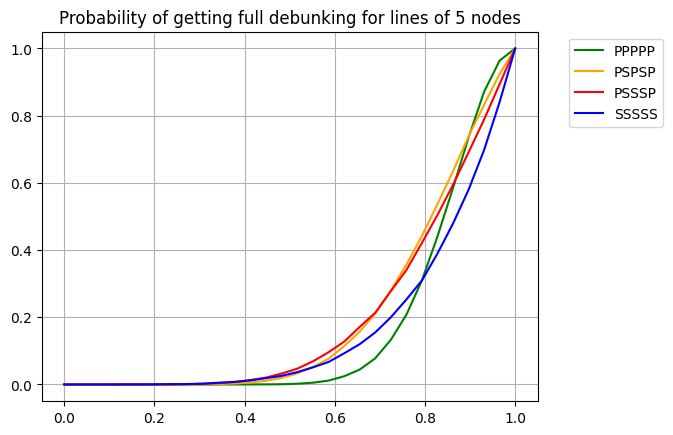

In [43]:
plt.plot(l_lambda, prob_ppppp, label='PPPPP', color='green')
plt.plot(l_lambda, prob_pspsp, label='PSPSP', color='orange')
plt.plot(l_lambda, prob_psssp, label='PSSSP', color='red')
plt.plot(l_lambda, prob_sssss, label='SSSSS', color='blue')

plt.title('Probability of getting full debunking for lines of 5 nodes')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

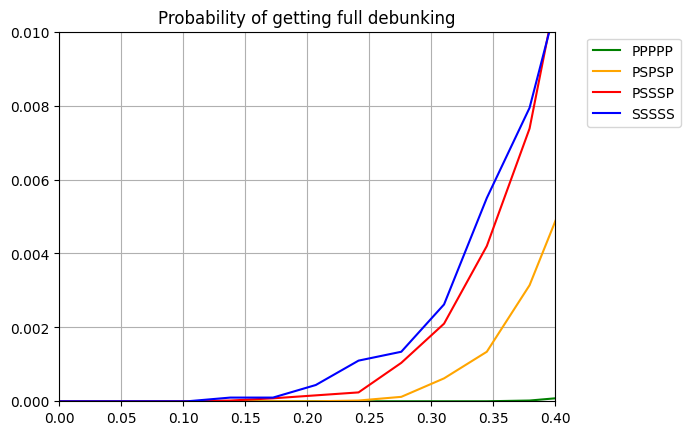

In [45]:
plt.plot(l_lambda, prob_ppppp, label='PPPPP', color='green')
plt.plot(l_lambda, prob_pspsp, label='PSPSP', color='orange')
plt.plot(l_lambda, prob_psssp, label='PSSSP', color='red')
plt.plot(l_lambda, prob_sssss, label='SSSSS', color='blue')
plt.xlim(0, 0.4)
plt.ylim(0, 0.01)

plt.title('Probability of getting full debunking')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#### Simulation 7 - Rumour Diffusion in Lines of Five Nodes (Reversing)

The goal of this simulation is to understand what are the best performing lines of five nodes when including *reversing* nodes. We will test the previous optimal combination to see how they are performing.

In [35]:
# the 30 values of lambda
l_lambda = np.linspace(0, 1, 30).tolist()

# lists to keep track of the simulations
prob_quarter_pspsp = [0 for i in range(len(l_lambda))]
prob_half_pspsp = [0 for i in range(len(l_lambda))]
prob_total_pspsp = [0 for i in range(len(l_lambda))]

prob_quarter_ppppp = [0 for i in range(len(l_lambda))]
prob_half_ppppp = [0 for i in range(len(l_lambda))]
prob_total_ppppp = [0 for i in range(len(l_lambda))]

prob_quarter_rsrsr = [0 for i in range(len(l_lambda))]
prob_half_rsrsr = [0 for i in range(len(l_lambda))]
prob_total_rsrsr = [0 for i in range(len(l_lambda))]

prob_quarter_rrrrr = [0 for i in range(len(l_lambda))]
prob_half_rrrrr = [0 for i in range(len(l_lambda))]
prob_total_rrrrr = [0 for i in range(len(l_lambda))]

prob_quarter_sssss = [0 for i in range(len(l_lambda))]
prob_half_sssss = [0 for i in range(len(l_lambda))]
prob_total_sssss = [0 for i in range(len(l_lambda))]

prob_quarter_prprp = [0 for i in range(len(l_lambda))]
prob_half_prprp = [0 for i in range(len(l_lambda))]
prob_total_prprp = [0 for i in range(len(l_lambda))]

for time in range(50_000):
    # 50,000 times
    for l in range(len(l_lambda)):
        # generating the nodes in the right order
        pspsp = [Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        ppppp = [Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        rsrsr = [Reversing([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Reversing([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Reversing([], l_lambda[l], 2)]
        rrrrr = [Reversing([], l_lambda[l], 2), Reversing([], l_lambda[l], 2), Reversing([], l_lambda[l], 2), Reversing([], l_lambda[l], 2), Reversing([], l_lambda[l], 2)]
        sssss = [Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]
        prprp = [Poisson([], l_lambda[l], 2), Reversing([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Reversing([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]

        # assembling the line
        pspsp = assemble_line(pspsp)
        ppppp = assemble_line(ppppp)
        rsrsr = assemble_line(rsrsr)
        rrrrr = assemble_line(rrrrr)
        sssss = assemble_line(sssss)
        prprp = assemble_line(prprp)

        # starting the infection
        pspsp[0].disease = True
        ppppp[0].disease = True
        rsrsr[0].disease = True
        rrrrr[0].disease = True
        sssss[0].disease = True
        prprp[0].disease = True

        # assigning debunkers
        pspsp[-1].debunker = True
        ppppp[-1].debunker = True
        rsrsr[-1].debunker = True
        rrrrr[-1].debunker = True
        sssss[-1].debunker = True
        prprp[-1].debunker = True

        # simulating the rumour
        rumour(pspsp, [pspsp[0]], [])
        rumour(ppppp, [ppppp[0]], [])
        rumour(rsrsr, [rsrsr[0]], [])
        rumour(rrrrr, [rrrrr[0]], [])
        rumour(sssss, [sssss[0]], [])
        rumour(prprp, [prprp[0]], [])

        # count > 25% infected and > 50% infected
        count_pspsp = 0
        count_ppppp = 0
        count_rsrsr = 0
        count_rrrrr = 0
        count_sssss = 0
        count_prprp = 0
        for i in range(5):
            if pspsp[i].debunker:
                count_pspsp += 1
            if ppppp[i].debunker:
                count_ppppp += 1
            if rsrsr[i].debunker:
                count_rsrsr += 1
            if rrrrr[i].debunker:
                count_rrrrr += 1
            if sssss[i].debunker:
                count_sssss += 1
            if prprp[i].debunker:
                count_prprp += 1
        
        if count_pspsp/5 >= 0.25:
            prob_quarter_pspsp[l] += 1
        if count_ppppp/5 >= 0.25:
            prob_quarter_ppppp[l] += 1
        if count_rsrsr/5 >= 0.25:
            prob_quarter_rsrsr[l] += 1
        if count_rrrrr/5 >= 0.25:
            prob_quarter_rrrrr[l] += 1
        if count_sssss/5 >= 0.25:
            prob_quarter_sssss[l] += 1
        if count_prprp/5 >= 0.25:
            prob_quarter_prprp[l] += 1

        if count_pspsp/5 >= 0.5:
            prob_half_pspsp[l] += 1
        if count_ppppp/5 >= 0.5:
            prob_half_ppppp[l] += 1
        if count_rsrsr/5 >= 0.5:
            prob_half_rsrsr[l] += 1
        if count_rrrrr/5 >= 0.5:
            prob_half_rrrrr[l] += 1
        if count_sssss/5 >= 0.5:
            prob_half_sssss[l] += 1
        if count_prprp/5 >= 0.5:
            prob_half_prprp[l] += 1

        if count_pspsp == 5:
            prob_total_pspsp[l] += 1
        if count_ppppp == 5:
            prob_total_ppppp[l] += 1
        if count_rsrsr == 5:
            prob_total_rsrsr[l] += 1
        if count_rrrrr == 5:
            prob_total_rrrrr[l] += 1
        if count_sssss == 5:
            prob_total_sssss[l] += 1
        if count_prprp == 5:
            prob_total_prprp[l] += 1

In [36]:
# calculating the probability
prob_quarter_pspsp = [x/50_000 for x in prob_quarter_pspsp]
prob_half_pspsp = [x/50_000 for x in prob_half_pspsp]
prob_total_pspsp = [x/50_000 for x in prob_total_pspsp]

prob_quarter_ppppp = [x/50_000 for x in prob_quarter_ppppp]
prob_half_ppppp = [x/50_000 for x in prob_half_ppppp]
prob_total_ppppp = [x/50_000 for x in prob_total_ppppp]

prob_quarter_rsrsr = [x/50_000 for x in prob_quarter_rsrsr]
prob_half_rsrsr = [x/50_000 for x in prob_half_rsrsr]
prob_total_rsrsr = [x/50_000 for x in prob_total_rsrsr]

prob_quarter_rrrrr = [x/50_000 for x in prob_quarter_rrrrr]
prob_half_rrrrr = [x/50_000 for x in prob_half_rrrrr]
prob_total_rrrrr = [x/50_000 for x in prob_total_rrrrr]

prob_quarter_sssss = [x/50_000 for x in prob_quarter_sssss]
prob_half_sssss = [x/50_000 for x in prob_half_sssss]
prob_total_sssss = [x/50_000 for x in prob_total_sssss]

prob_quarter_prprp = [x/50_000 for x in prob_quarter_prprp]
prob_half_prprp = [x/50_000 for x in prob_half_prprp]
prob_total_prprp = [x/50_000 for x in prob_total_prprp]

The resulting curves for the different combinations are:

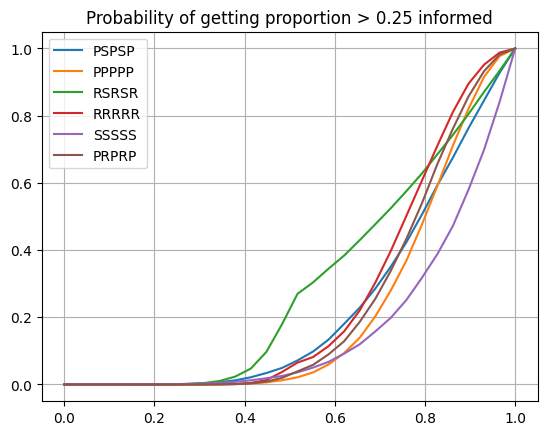

In [37]:
# plotting
plt.plot(l_lambda, prob_quarter_pspsp, label='PSPSP')
plt.plot(l_lambda, prob_quarter_ppppp, label='PPPPP')
plt.plot(l_lambda, prob_quarter_rsrsr, label='RSRSR')
plt.plot(l_lambda, prob_quarter_rrrrr, label='RRRRR')
plt.plot(l_lambda, prob_quarter_sssss, label='SSSSS')
plt.plot(l_lambda, prob_quarter_prprp, label='PRPRP')

plt.title('Probability of getting proportion > 0.25 informed')
plt.grid(True)
plt.legend()
plt.show()

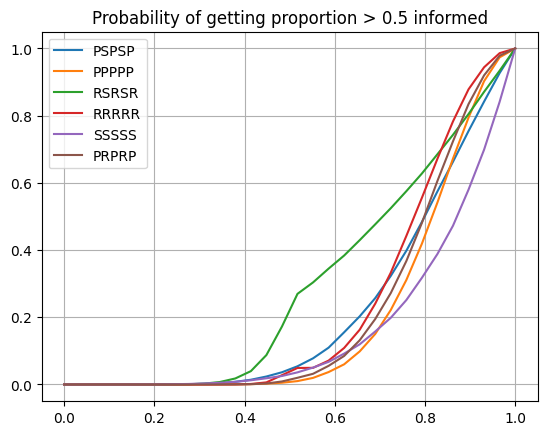

In [38]:
# plotting
plt.plot(l_lambda, prob_half_pspsp, label='PSPSP')
plt.plot(l_lambda, prob_half_ppppp, label='PPPPP')
plt.plot(l_lambda, prob_half_rsrsr, label='RSRSR')
plt.plot(l_lambda, prob_half_rrrrr, label='RRRRR')
plt.plot(l_lambda, prob_half_sssss, label='SSSSS')
plt.plot(l_lambda, prob_half_prprp, label='PRPRP')

plt.title('Probability of getting proportion > 0.5 informed')
plt.grid(True)
plt.legend()
plt.show()

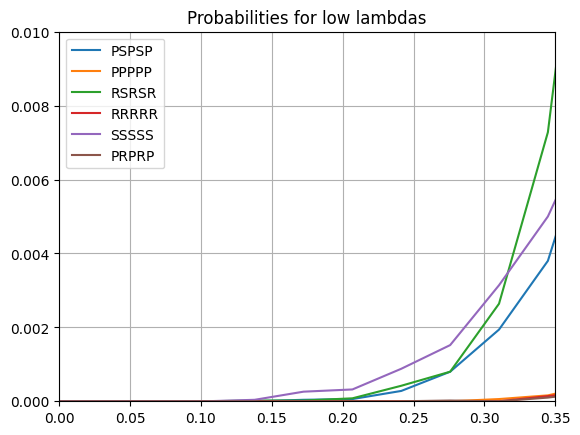

In [39]:
# plotting
plt.plot(l_lambda, prob_half_pspsp, label='PSPSP')
plt.plot(l_lambda, prob_half_ppppp, label='PPPPP')
plt.plot(l_lambda, prob_half_rsrsr, label='RSRSR')
plt.plot(l_lambda, prob_half_rrrrr, label='RRRRR')
plt.plot(l_lambda, prob_half_sssss, label='SSSSS')
plt.plot(l_lambda, prob_half_prprp, label='PRPRP')
plt.xlim(0, 0.35)
plt.ylim(0, 0.01)

plt.title('Probabilities for low lambdas')
plt.grid(True)
plt.legend()
plt.show()

#### Simulation 8 - Stars

In [6]:
def star_builder(center, leaves):
    for leaf in leaves:
        center.edges.append(leaf)
        leaf.edges.append(center)

    return leaves + [center]

In [67]:
# the 30 values of lambda
l_lambda = np.linspace(0, 1, 30).tolist()
# probabilities
prob_pp_star = [0 for i in range(len(l_lambda))]
prob_ps_star = [0 for i in range(len(l_lambda))]
prob_sp_star = [0 for i in range(len(l_lambda))]
prob_ss_star = [0 for i in range(len(l_lambda))]

for time in range(50_000):
    for l in range(len(l_lambda)):
        # Pp
        center_pp = Poisson([], l_lambda[l], 2)
        leaves_pp = [Poisson([], l_lambda[l], 2) for n in range(100)]
        pp_star = star_builder(center_pp, leaves_pp)

        pp_star[0].disease = True
        pp_star[1].debunker = True
        rumour(pp_star, [pp_star[0]], [])
        
        count_pp = 0
        for node in pp_star:
            if node.debunker:
                count_pp += 1
        if count_pp == len(pp_star):
            prob_pp_star[l] += 1

        # Ps
        center_ps = Sticky([], l_lambda[l], 2)
        leaves_ps = [Poisson([], l_lambda[l], 2) for n in range(100)]
        ps_star = star_builder(center_ps, leaves_ps)

        ps_star[0].disease = True
        ps_star[1].debunker = True
        rumour(ps_star, [ps_star[0]], [])
                
        count_ps = 0
        for node in ps_star:
            if node.debunker:
                count_ps += 1
        if count_ps == len(ps_star):
            prob_ps_star[l] += 1
            
        # Sp
        center_sp = Poisson([], l_lambda[l], 2)
        leaves_sp = [Sticky([], l_lambda[l], 2) for n in range(100)]
        sp_star = star_builder(center_sp, leaves_sp)

        sp_star[0].disease = True
        sp_star[1].debunker = True
        rumour(sp_star, [sp_star[0]], [])
                
        count_sp = 0
        for node in sp_star:
            if node.debunker:
                count_sp += 1
        if count_sp == len(sp_star):
            prob_sp_star[l] += 1
            
        # Ss
        center_ss = Sticky([], l_lambda[l], 2)
        leaves_ss = [Sticky([], l_lambda[l], 2) for n in range(100)]
        ss_star = star_builder(center_ss, leaves_ss)

        ss_star[0].disease = True
        ss_star[1].debunker = True
        rumour(ss_star, [ss_star[0]], [])

        count_ss = 0
        for node in ss_star:
            if node.debunker:
                count_ss += 1
        if count_ss == len(ss_star):
            prob_ss_star[l] += 1

prob_pp_star = [x/50_000 for x in prob_pp_star]
prob_ps_star = [x/50_000 for x in prob_ps_star]
prob_sp_star = [x/50_000 for x in prob_sp_star]
prob_ss_star = [x/50_000 for x in prob_ss_star]

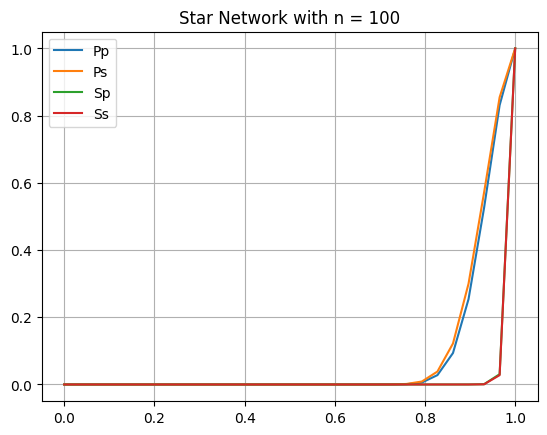

In [69]:
# plotting
plt.plot(l_lambda, prob_pp_star, label='Pp')
plt.plot(l_lambda, prob_ps_star, label='Ps')
plt.plot(l_lambda, prob_sp_star, label='Sp')
plt.plot(l_lambda, prob_ss_star, label='Ss')

plt.title('Star Network with n = 100')
plt.grid(True)
plt.legend()
plt.show()

#### Simulation 9 - Heterogeneity vs Homogeneity

In [7]:
# the 30 values of lambda
l_lambda = np.linspace(0, 1, 30).tolist()

# lists to keep track of the simulations
prob_ppppp = [0 for i in range(len(l_lambda))]
prob_pspsp = [0 for i in range(len(l_lambda))]
prob_sssss = [0 for i in range(len(l_lambda))]

for time in range(50_000):
    # 50,000 times
    for l in range(len(l_lambda)):
        # generating the nodes in the right order
        ppppp = [Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        pspsp = [Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Poisson([], l_lambda[l], 2)]
        sssss = [Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2), Sticky([], l_lambda[l], 2)]

        # assembling the line
        ppppp = assemble_line(ppppp)
        pspsp = assemble_line(pspsp)
        sssss = assemble_line(sssss)

        # starting the infection
        ppppp[0].disease = True
        pspsp[0].disease = True
        sssss[0].disease = True

        # assigning debunkers
        ppppp[-1].debunker = True
        pspsp[-1].debunker = True
        sssss[-1].debunker = True

        # simulating the rumour
        rumour(ppppp, [ppppp[0]], [])
        rumour(pspsp, [pspsp[0]], [])
        rumour(sssss, [sssss[0]], [])

        # count full infections
        count_ppppp = 0
        count_pspsp = 0
        count_sssss = 0
        for i in range(5):
            if ppppp[i].debunker:
                count_ppppp += 1
            if pspsp[i].debunker:
                count_pspsp += 1
            if sssss[i].debunker:
                count_sssss += 1

        if count_ppppp == 5:
                prob_ppppp[l] += 1
        if count_pspsp == 5:
                prob_pspsp[l] += 1
        if count_sssss == 5:
                prob_sssss[l] += 1

In [8]:
prob_ppppp = [x/50_000 for x in prob_ppppp]
prob_pspsp = [x/50_000 for x in prob_pspsp]
prob_sssss = [x/50_000 for x in prob_sssss]

c:\Users\loren\Desktop\Burstiness\myenv\Lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


       Homogeneous 1  Homogeneous 2  Heterogeneous
count      30.000000      30.000000      30.000000
mean        0.180706       0.177957       0.214579
std         0.319329       0.275914       0.316856
min         0.000000       0.000000       0.000000
25%         0.000000       0.001050       0.000150
50%         0.001490       0.031890       0.026450
75%         0.189345       0.237960       0.337620
max         1.000000       1.000000       1.000000


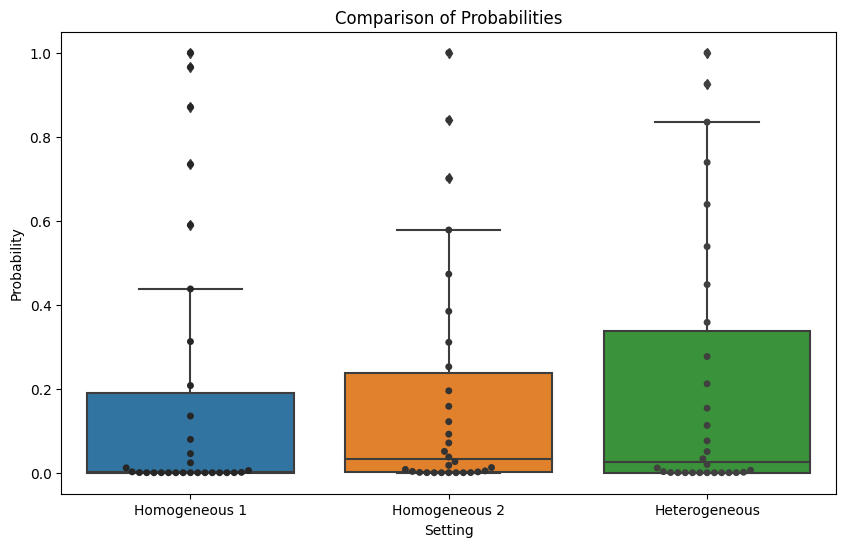

In [9]:
df = pd.DataFrame({
    'Homogeneous 1': prob_ppppp,
    'Homogeneous 2': prob_sssss,
    'Heterogeneous': prob_pspsp
})

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
sns.swarmplot(data=df, color=".25")

# Adding the title and labels
plt.title('Comparison of Probabilities')
plt.ylabel('Probability')
plt.xlabel('Setting')

# Display statistical summary
summary = df.describe()
print(summary)

plt.show()

In [10]:
ratio_one = [1 for _ in range(30)] # red line

ratio_p = [1]
ratio_s = [1]

for i in range(1,30):
    if prob_ppppp[i] != 0:
        ratio_p.append(prob_pspsp[i]/prob_ppppp[i])
    elif prob_ppppp[i] == 0 and prob_pspsp[i] == 0:
        ratio_p.append(1)
    else:
        ratio_p.append(prob_pspsp[i]/1)

    if prob_sssss[i] != 0:
        ratio_s.append(prob_pspsp[i]/prob_sssss[i])
    elif prob_sssss[i] == 0 and prob_pspsp[i] == 0:
        ratio_s.append(1)
    else:
        ratio_s.append(prob_pspsp[i]/1)